In [191]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from plotly.offline import init_notebook_mode, iplot
import plotly
import plotly.graph_objs as go
import plotly.graph_objs as gobj
from plotly.subplots import make_subplots

init_notebook_mode(connected=True)
#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 13,7

#### Про данные

Источник - https://www.kaggle.com/imdevskp/corona-virus-report#covid_19_clean_complete.csv

Данные про короновирус (COVID-19).

Короновирус обнаружен в Wuhan, Китай. Люди заболевают пневмонией без видимых причин, существующие лекарства не очень эффективны. Вирус передаётся от человека к человеку.
Распространение вируса активно началось в середине января 2020.
Каждая строка отчета представляет данные на страну/регион + дата.

Описание полей: <br>
Province/State - Провинция/Штат <br>
Country/Region - Страна/Регион <br>
Lat -            Широта <br>
Long -           Долгота <br>
Date -           Дата отчета <br>
Confirmed -      <b> Кумулятивное </b> количество людей с подтвержденным вирусом <br>
Deaths -         <b> Кумулятивное </b> количество людей, погибших от вируса <br>
Recovered -      <b> Кумулятивное </b> количество вылеченных людей <br>

In [216]:
df_corona = pd.read_csv('corona-virus-report/covid_19_clean_complete.csv')

In [217]:
df_corona.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21222 entries, 0 to 21221
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Province/State  6480 non-null   object 
 1   Country/Region  21222 non-null  object 
 2   Lat             21222 non-null  float64
 3   Long            21222 non-null  float64
 4   Date            21222 non-null  object 
 5   Confirmed       21222 non-null  int64  
 6   Deaths          21222 non-null  int64  
 7   Recovered       21222 non-null  int64  
dtypes: float64(2), int64(3), object(3)
memory usage: 1.3+ MB


In [220]:
# df_corona[df_corona['Country/Region'] == 'Russia']

In [221]:
# df_corona.groupby('Country/Region')[['Confirmed', 'Deaths']].max()

In [222]:
df_corona['date_format'] = pd.to_datetime(df_corona['Date'])

In [241]:
# test_df = df_corona[(df_corona['Country/Region'] == 'Russia') & (df_corona.date_format >= '2020-04-10')]
# test_df['previous_date'] = test_df.date_format+pd.DateOffset(-1)
# test_df

In [240]:
# test_df.merge(test_df.shift()[['Province/State', 'Country/Region', 'Confirmed', 'Deaths'\
#                               , 'Recovered', 'date_format']]\
#               , how='left', left_on=['Province/State', 'Country/Region', test_df.date_format+pd.DateOffset(-1)]\
#               ,right_on=['Province/State', 'Country/Region', 'date_format'])

In [ ]:
# df_corona[['Country/Region', 'Confirmed', 'Deaths', 'Recovered','date_format']]

### 1. Базовый график для понимания общей тенденции к распространению вируса, летальным исходам и выздоровлению

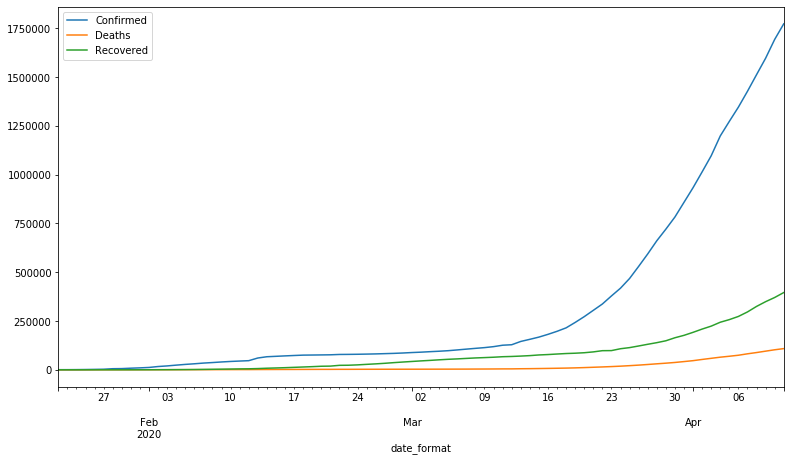

In [242]:
df_corona.groupby('date_format').sum()[['Confirmed', 'Deaths', 'Recovered']].plot()

#### Выводы: видно, что прирост заболевших стремительно растет, с намного большей скоростью, чем кол-во выздоровевших. С другой стороны, кол-во смертей растет с самым медленным темпом. К тому же, резкий перелом в заболевших произошел где-то в конце марта, что говорит скорее о том, что вирус стали лучше определять и разглашать информацию об этом, чем раньше.

### 2. Теперь посмотрим, какая ситуация сложилась в странах с максимальным кол-вом идентифицированных, на последнюю дату выгрузки

In [243]:
corona_country_group = df_corona[df_corona.date_format == max(df_corona.date_format)].groupby('Country/Region')\
.sum()[['Confirmed', 'Deaths', 'Recovered']].sort_values('Confirmed', ascending=False)

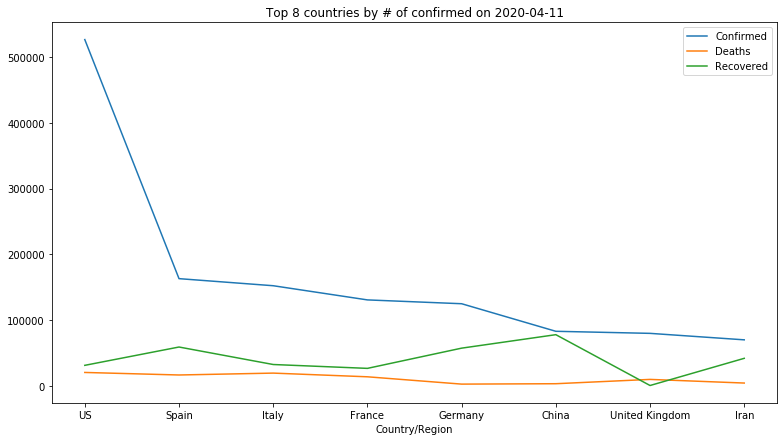

In [247]:
corona_country_group.head(8).plot()
plt.title(f'Top 8 countries by # of confirmed on {str(max(df_corona.date_format))[:10]}')
plt.show()

#### Выводы: по тройке "лидеров" - ожидаемый результат, об этом известно из СМИ. Скорее удивила Германия и Франция, которые оказались также с большим кол-ом зараженным, и очень разочаровала Великобритания с плохим уровнем выздоровления (даже уровень смертей превышает уровень выздоровления). Возникает только вопрос - почему в лидерах оказались страны с самыми высокими уровнями медицины и жизни в целом?

### 3. По предыдущему графику хочется посмотреть, что происходит с соседями стран, которые попали в топ 8.

#### 3.1. Смотрим идентифицированных

In [255]:
#initializing the data variable
data = dict(type = 'choropleth',
            locations = corona_country_group.index,
            locationmode = 'country names',
            colorscale= [[0, 'rgb(255,250,205)'],[0.1, 'rgb(255,215,0)']\
                         ,[0.5, 'rgb(255,69,0)'] ,[1, 'rgb(153,0,0)']],
            z=corona_country_group.Confirmed,
            colorbar = {'title':'Confirmed cases', 'len':350,'lenmode':'pixels' })
#initializing the layout variable
layout = dict(geo = {'scope':'world'},\
title_text = f'COVID-19 from {str(min(df_corona.date_format))[:10]} to {str(max(df_corona.date_format))[:10]}')
# Initializing the Figure object by passing data and layout as arguments.
col_map = gobj.Figure(data = [data],layout = layout)

#plotting the map
iplot(col_map)

#### Выводы: на графике видно, что соседи самых заболевших стран часто относятся к самым "незаболевшим". Например, США и Мексика, Германия и Чехия, Туркция и Болгария и т.д. Поскольку уровень жизни в таких странах хуже или схож с заболевшими напрашивается вывод, что вирус либо не могут идентифицировать, либо не сообщают.

#### 3.2 Смотрим выздоровевших

In [249]:
#initializing the data variable
data = dict(type = 'choropleth',
            locations = corona_country_group.index,
            locationmode = 'country names',
            colorscale= [[0, 'rgb(245,255,250)'], [1, 'rgb(60,179,113)']],
            z=corona_country_group.Recovered,
            colorbar = {'title':'Recovered cases', 'len':350,'lenmode':'pixels' })
# Initializing the Figure object by passing data and layout as arguments.
col_map = gobj.Figure(data = [data],layout = layout)

#plotting the map
iplot(col_map)

#### Вывод: тут особых теорий нет, вес и так понятно, радует, что Китай очень успешно справляется с болезнью, возможно, это означает, что и остальные страны тоже скоро будут справляться.

### 4. "Зеленая" карта хорошо показала урвоень лечения вируса в целом, но хочется узнать, каков % лечения относительно заболевших.

In [256]:
df_corona['recovery_level'] = 100*df_corona['Recovered']/df_corona['Confirmed']

In [257]:
df_corona[df_corona['Confirmed'] != 0].head()

,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered,date_format,recovery_level
49,Anhui,China,31.8257,117.2264,1/22/20,1,0,0,2020-01-22,0.0
50,Beijing,China,40.1824,116.4142,1/22/20,14,0,0,2020-01-22,0.0
51,Chongqing,China,30.0572,107.8740,1/22/20,6,0,0,2020-01-22,0.0
52,Fujian,China,26.0789,117.9874,1/22/20,1,0,0,2020-01-22,0.0
54,Guangdong,China,23.3417,113.4244,1/22/20,26,0,0,2020-01-22,0.0


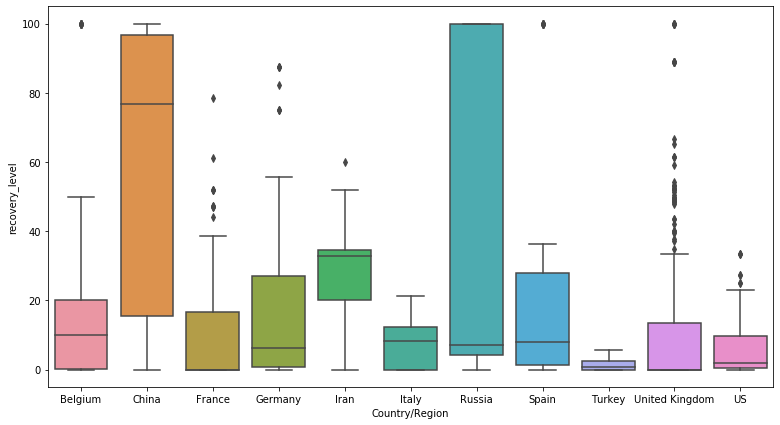

In [258]:
# top_recovery = df_corona.Platform.value_counts().sort_values(ascending = False).head(5).index.values
top_confirmed = df_corona.groupby('Country/Region')['Confirmed'].max()\
    .sort_values(ascending=False).head(10).index.values
top_confirmed_rus = np.append(top_confirmed, 'Russia')
ax = sns.boxplot(x="Country/Region", y="recovery_level", 
            data=df_corona[df_corona['Country/Region'].isin(top_confirmed_rus)])


#### Строю ящик с усами в plotly, чтобы при наведении показывались значения - на графике сверху их нужно либо добавить, тогда будет перезагруз, либо не очень понятно.

In [259]:
data = []

for country in top_confirmed_rus:
    data.append(
        go.Box(y=df_corona[df_corona['Country/Region']==country].recovery_level, 
               name=country)
    )
iplot(data, show_link = False)

#### Вывод: вывод по бокс плоту напишу ниже - после того, как его перестрою.

### 5. Посмотрим на уровень выздоровления относительно зараженных на временной шкале у самых зараженных стран.

In [260]:
df_top_conf_by_date = df_corona[df_corona['Country/Region'].isin(top_confirmed_rus)]\
    .groupby(['date_format', 'Country/Region']).mean()['recovery_level'].unstack()

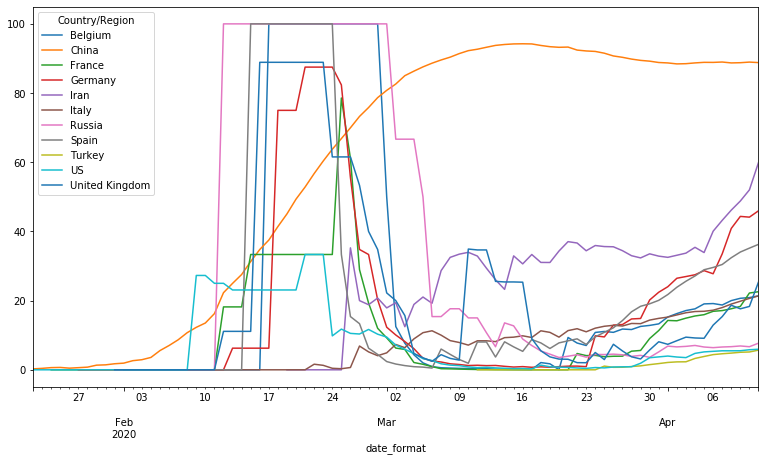

In [261]:
df_top_conf_by_date.plot()

In [262]:
def plotly_line_plot(df, title = ''):
    data = []
    
    for column in df.columns:
        trace = go.Scatter(
            x = df.index,
            y = df[column],
            mode = 'lines',
            name = column
        )
        data.append(trace)
    
    layout = dict(title = title)
    fig = dict(data = data, layout = layout)
    iplot(fig, show_link=False)

In [263]:
plotly_line_plot(
    df_top_conf_by_date,
    title = 'Mean recovery level'
)

#### Вывод: (опять в plotly задублировала для значений) в глаза бросается странное поведение в преиод с 12 февраля по 1 марта. У нескольких стран выздоровление на уровне 100 %, больше похоже на провал в данных, нежели на реальную ситуацию, т.к. потом уровень выздоровления очень низко упал. Еще интересен Китай - видно, что с 5 февраля начался резкий рост выздоровления и очень хорошо держится до сих пор. Хорошо расследовать, какие действия в это время начал принимать Китай, какая была там температура и т.д. (наверняка это уже сделали))))

### 6. После анализа предыдущего графика хочу еще раз посомтреть на ящики, но уже после 6 марта (с 1 по 5 еще были какие-то скачки).

In [265]:
df_corona_clean = df_corona[df_corona.date_format >= '2020-03-06']

In [266]:
data = []

for country in top_confirmed_rus:
    data.append(
        go.Box(y=df_corona_clean[df_corona_clean['Country/Region']==country].recovery_level, 
               name=country)
    )
iplot(data, show_link = False)

#### Вывод: ну вот) кратина немного изменилась. Россия - пока все печально, средний уровень выздоровления не достигает и 7%, а в самый лучший день было только 17,6%, единственное, что радует, это то, что мы не входит в топ заболевших. В целом по остальным, кроме Китая, видно, что справиляется с вирусом только Иран, в UK есть положительные выбросы - можно посмотреть, это либо ошибка в данных, либо где-то врачам удалось перегибать ситуацию в положительную сторону. В США нужна помощь, даже ни одного случая больше 6 % нет... Турция заболела недавно, но в отличие от Ирана, плохо справляется, хотя у них схожие погодные условия - стоит обратить на Иран внимание. Германия очень неоднозначная - большой ящик, скорее всего очень различается уровень лечения в регионах.

In [270]:
df_corona[(df_corona.Confirmed != 0)&(df_corona['Country/Region']\
                                      .isin(top_confirmed_rus))].groupby('Country/Region')\
.date_format.min().sort_values()

Country/Region
China            2020-01-22
US               2020-01-22
France           2020-01-24
Germany          2020-01-27
Italy            2020-01-31
Russia           2020-01-31
United Kingdom   2020-01-31
Spain            2020-02-01
Belgium          2020-02-04
Iran             2020-02-19
Turkey           2020-03-11
Name: date_format, dtype: datetime64[ns]

### 7. Смотрю отдельно по России и Китаю

In [271]:
corona_russia_stat = df_corona[df_corona['Country/Region'] == 'Russia']\
    [['date_format','Confirmed', 'Deaths', 'Recovered', 'recovery_level']]
corona_russia_stat[corona_russia_stat.date_format == '2020-02-13'].head()

,date_format,Confirmed,Deaths,Recovered,recovery_level
5951,2020-02-13,2,0,2,100.0


In [272]:
def create_plotly_with_secondary_axis(df, country='Russia'):

    # Create figure with secondary y-axis
    fig = make_subplots(specs=[[{"secondary_y": True}]])

    fig.add_trace (
    go.Scatter(
        x=df.date_format,
        y=df.Confirmed,
        name='Confirmed'
    )
    
        ,secondary_y=False,
    )

    fig.add_trace(

    go.Scatter(
        x=df.date_format,
        y=df.Deaths,
        name='Deaths'
    )
        ,secondary_y=False,
    )

    fig.add_trace(
        go.Scatter(
        x=df.date_format,
        y=df.Recovered,
        name='Recovered'
    )
        ,secondary_y=False,
    )

    fig.add_trace(
        go.Scatter(
        x=df.date_format,
        y=df.recovery_level,
        name='Recovery level'
    )
        ,secondary_y=True,
    )
  
    # Add figure title
    fig.update_layout(
        title_text=f"Statistics of COVID-19 in {country}"
    )

    # Set y-axes titles
    fig.update_yaxes(title_text="<b>primary</b> # of cases", secondary_y=False)
    fig.update_yaxes(title_text="<b>secondary</b> % of recovery", secondary_y=True)

    fig.show()

In [273]:
create_plotly_with_secondary_axis(corona_russia_stat)

In [281]:
def create_df_for_plotly_w_secondary(df, country):
    return df_corona[df_corona['Country/Region'] == country]\
    [['date_format','Confirmed', 'Deaths', 'Recovered', 'recovery_level']].groupby('date_format').agg({'Confirmed': 'sum', 'Deaths': 'sum', 'Recovered':'sum'\
                                              , 'recovery_level': 'mean'}).reset_index()

In [283]:
create_plotly_with_secondary_axis(create_df_for_plotly_w_secondary(df_corona, 'China'), 'China')

#### Вывод: по Китаю видно, что вирус остановился, когда прирост заболевших стал падать, т.е. лекарства и мед.аппараты скорее всего не играют решающей роли в победе над вирусом, сейчас нужно только остановить распространение. В России еще идет рост вируса, как в первое время в Китае, пока не вели жесткие ограничения, посмотрим, как ситуация поменяется в ближайшую неделю, а еще посмотрим Италию, в которой уже введены жесткие меры:

In [284]:
create_plotly_with_secondary_axis(create_df_for_plotly_w_secondary(df_corona, 'Italy'), 'Italy')

В Италии рост продолжается, значит меры еще не такие жесткие как в Китае, иначе как вирус может распространяться?